In [67]:
# Load images and labels
import os
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

# # Define the input directory
input_dir = 'D:/ML_LOCAL_WIN/archive_small'

# Initialize lists to store images and labels
images = []
labels = []

# Loop through each folder (class name) in the input directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):  # Ensure it's a directory
        for file_name in os.listdir(category_path):
            if file_name.endswith('.jpeg') or file_name.endswith('.png'):  # Check for valid image files
                img_path = os.path.join(category_path, file_name)
                try:
                    # Open and preprocess the image
                    img = Image.open(img_path)
                    # img = img.resize((128, 128))  # Resize to 128x128
                    img_array = np.array(img)
                    
                    # Append the image and its label
                    images.append(img_array)
                    labels.append(category)  # Use the folder name as the label
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Print some information about the loaded data
print(f"Loaded {len(images)} images.")
print(f"Image shape: {images[0].shape} ")
print(f"Labels: {np.unique(labels)}")


Loaded 600 images.
Image shape: (64, 64) 
Labels: ['AbdomenCT' 'BreastMRI' 'Hand' 'HeadCT']


In [68]:
from sklearn.model_selection import train_test_split

# Set random_state for reproducibility
random_state = 42

# Split into train and test only
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=random_state, stratify=labels
)

print(f"Shape Train set: {X_train.shape}, labels: {y_train.shape}")
print(f"Shape Test set: {X_test.shape}, labels:{y_test.shape}")

Shape Train set: (420, 64, 64), labels: (420,)
Shape Test set: (180, 64, 64), labels:(180,)


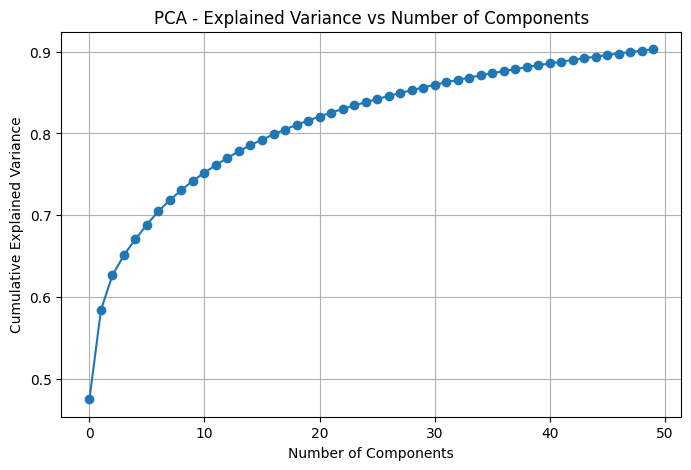

Original shape: (420, 4096)
PCA reduced shape: (420, 50)


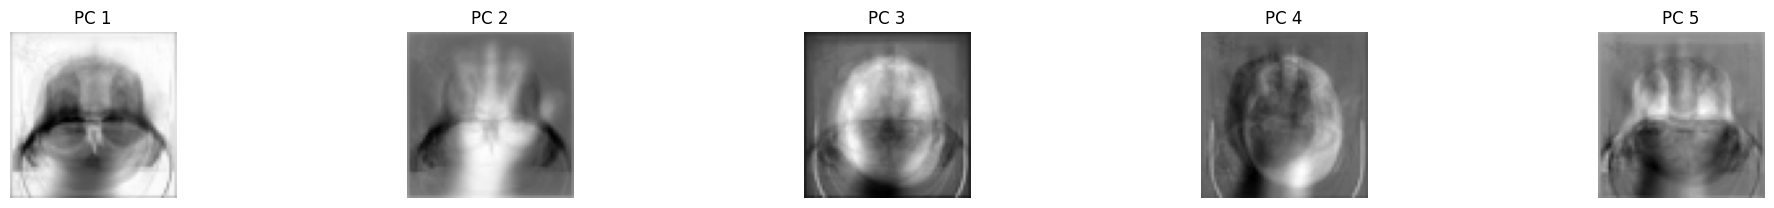

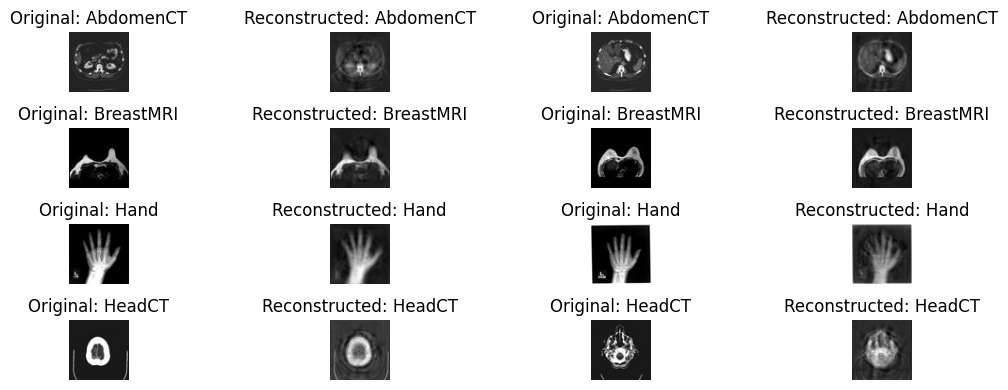

In [69]:
# PCA and visualization

import os
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt



# Flatten images for PCA
num_samples = X_train.shape[0]
flattened_images = X_train.reshape(num_samples, -1)

# Standardize
scaler = StandardScaler()
flattened_images_std = scaler.fit_transform(flattened_images)

# Apply PCA
# If you apply PCA on the whole data (including the test data) before training the model,
# then you in fact use some information from the test data.
# Thus, you cannot really judge the behaviour of your model using the test data,
# because it is not an unseen data anymore.
n_components = 50
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(flattened_images_std)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

print(f"Original shape: {flattened_images.shape}")
print(f"PCA reduced shape: {principal_components.shape}")

# Plot the first 5 principal components
plt.figure(figsize=(20, 4))
for i in range(5):     
    plt.subplot(2, 5, i + 1)
    component = pca.components_[i].reshape(X_train[0].shape)
    plt.imshow(component, cmap='gray')
    plt.title(f'PC {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()
# Plot the first 5 images of the training set
# Inverse transform to reconstruct images from PCA
reconstructed = pca.inverse_transform(principal_components)
reconstructed_images = scaler.inverse_transform(reconstructed)
reconstructed_images = reconstructed_images.reshape(X_train.shape)

# Plot 2 images per class: original vs reconstructed
unique_classes = np.unique(y_train)
images_per_class = 2

plt.figure(figsize=(10, 4))  # Bigger images

plot_idx = 1
for class_label in unique_classes:
    # Find indices for this class
    class_indices = np.where(y_train == class_label)[0][:images_per_class]
    for i, idx in enumerate(class_indices):
        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(X_train[idx], cmap='gray')
        plt.title(f"Original: {class_label}")
        plt.axis('off')
        plot_idx += 1

        plt.subplot(len(unique_classes), images_per_class * 2, plot_idx)
        plt.imshow(reconstructed_images[idx], cmap='gray')
        plt.title(f"Reconstructed: {class_label}")
        plt.axis('off')
        plot_idx += 1

plt.tight_layout()
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.show()

In [70]:
# Logistic regression whithot PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

# Flatten images for classification
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

# Train logistic regression classifier
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_std, y_train)

# Predict on test set
y_pred = clf.predict(X_test_std)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9944444444444445

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.98      1.00      0.99        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.98      0.99        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



In [71]:
# just checkig 
num_samples = X_train.shape[0]
print(f"Number of samples: {num_samples}")
print("---------------------------------------")
flattened_images = X_train.reshape(num_samples, -1)
print(f"Flattened images shape: {flattened_images.shape}")
print("---------------------------------------")
print("pricipal components shape: ", principal_components.shape)
print("---------------------------------------")   
print("principal components=",principal_components)

Number of samples: 420
---------------------------------------
Flattened images shape: (420, 4096)
---------------------------------------
pricipal components shape:  (420, 50)
---------------------------------------
principal components= [[-37.34229163  37.7042807  -11.40124359 ...  -1.50500613   1.28704161
   -4.08730651]
 [-48.7812024  -30.14213004  -8.0418964  ...  -0.29824438  -0.80992564
    1.34580583]
 [-15.56909213  30.15862672 -38.81307213 ...  -0.51194055  -4.51630964
   -3.03130058]
 ...
 [ -1.43134825  -1.55132442  27.29772787 ...   3.67243261   2.4625247
    1.65443315]
 [-48.18992394 -31.17271215   0.28316358 ...  -1.32783115  -1.58920607
   -3.62448499]
 [-10.49751327  18.44966174  20.75384512 ...   3.11135589  -1.56864017
    1.61136569]]


In [72]:
# Logistic regreression which uses PCA

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Flatten and standardize validation and test sets using the same scaler as training
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_std = scaler.transform(X_test_flat)

# Apply PCA transformation using the same PCA fitted on training data
X_test_pca = pca.transform(X_test_std)

# Use PCA-reduced features for training
X_train_pca = principal_components  # Already computed for training set

# Train multiclass logistic regression classifier
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)
clf.fit(X_train_pca, y_train)

# Predict on test set
y_pred = clf.predict(X_test_pca)

# Evaluate
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Test Accuracy: 0.9888888888888889

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 2  0 43  0]
 [ 0  0  0 45]]


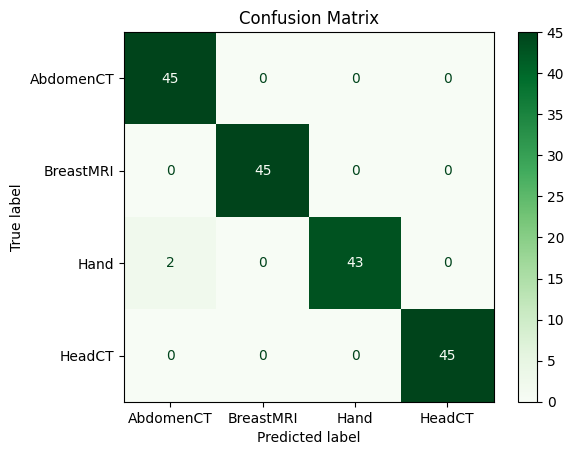

Accuracy: 0.9888888888888889

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



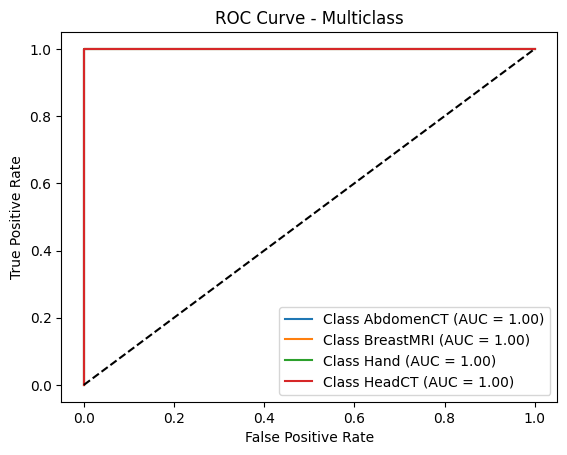

In [73]:
# Assessment of the model's performance
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
# y_test: true labels, y_pred: predicted labels, y_score: probability estimates or decision function

# Confusion Matrix compute and doisplay
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# Display confusion matrix using scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC (for binary or one-vs-rest multiclass)
if hasattr(clf, "predict_proba"):
    y_score = clf.predict_proba(X_test_pca)
elif hasattr(clf, "decision_function"):
    y_score = clf.decision_function(X_test_pca)
else:
    y_score = None

if y_score is not None:
    # Binarize the output for multiclass
    from sklearn.preprocessing import label_binarize
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    if y_score.ndim == 1 or y_score.shape[1] == 1:
        # Binary case
        fpr, tpr, _ = roc_curve(y_test_bin, y_score[:, 1] if y_score.ndim > 1 else y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    else:
        # Multiclass case: plot ROC for each class
        for i, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Multiclass')
        plt.legend(loc="lower right")
        plt.show()
else:
    print("ROC curve and AUC not available for this classifier.")

In [74]:
# Grid search for best hyperparameters in Logistic Regression with PCA features

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Define parameter grid
param_grid = {
    'C': np.logspace(-4,4,20),
    'solver': ['lbfgs', 'saga'],
    'multi_class': ['multinomial'],
    'max_iter': [100,1000,2500, 5000]
}

# Initialize Logistic Regression (no need to set random_state for grid search)
logreg = LogisticRegression()

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    n_jobs=-1,
    verbose=2
)

# Fit on PCA-reduced training data
grid_search.fit(X_train_pca, y_train)

# Best parameters and score
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate on test set
y_pred = grid_search.predict(X_test_pca)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 160 candidates, totalling 480 fits
Best parameters found: {'C': np.float64(0.012742749857031334), 'max_iter': 100, 'multi_class': 'multinomial', 'solver': 'lbfgs'}
Best cross-validation score: 0.9904761904761905
Test Accuracy: 0.9888888888888889

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---------------------------------------------------
GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'max_iter': [100, 1000, 2500, 5000],
                         'multi_class': ['multinomial'],
                         'solver': ['lbfgs', 'saga']},
             verbose=2)
---------------------------------------------------
Confusion Matrix:
 [[45  0  0  0]
 [ 0 45  0  0]
 [ 2  0 43  0]
 [ 0  0  0 45]]


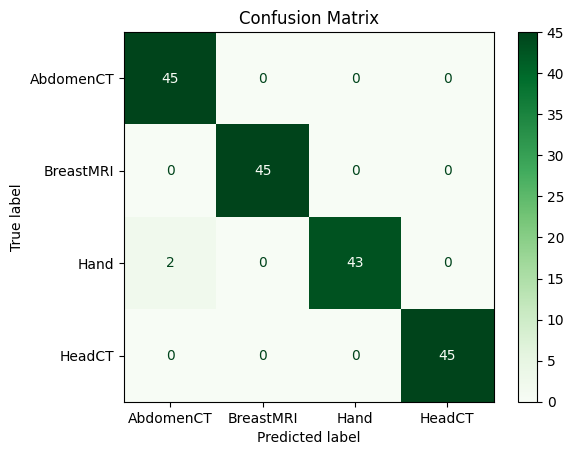

Accuracy: 0.9888888888888889

Classification Report:
               precision    recall  f1-score   support

   AbdomenCT       0.96      1.00      0.98        45
   BreastMRI       1.00      1.00      1.00        45
        Hand       1.00      0.96      0.98        45
      HeadCT       1.00      1.00      1.00        45

    accuracy                           0.99       180
   macro avg       0.99      0.99      0.99       180
weighted avg       0.99      0.99      0.99       180



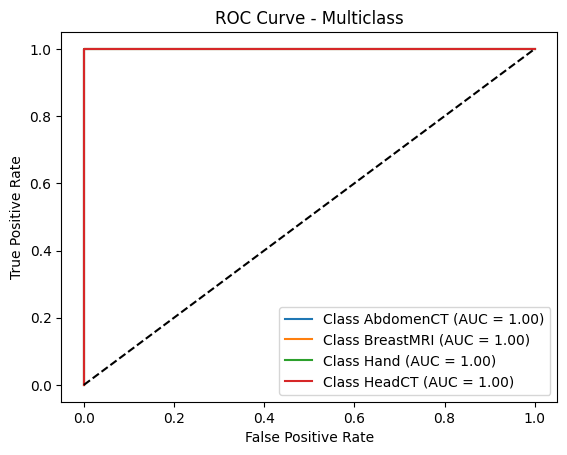

In [75]:
# Assessment of the model's performance
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
)
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
# y_test: true labels, y_pred: predicted labels, y_score: probability estimates or decision function

y_pred = grid_search.predict(X_test_pca)
clf = grid_search
print("---------------------------------------------------")
print(clf)
print("---------------------------------------------------")

# Confusion Matrix compute and doisplay
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
# Display confusion matrix using scikit-learn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)


# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC (for binary or one-vs-rest multiclass)
if hasattr(clf, "predict_proba"):
    y_score = clf.predict_proba(X_test_pca)
elif hasattr(clf, "decision_function"):
    y_score = clf.decision_function(X_test_pca)
else:
    y_score = None

if y_score is not None:
    # Binarize the output for multiclass
    from sklearn.preprocessing import label_binarize
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    if y_score.ndim == 1 or y_score.shape[1] == 1:
        # Binary case
        fpr, tpr, _ = roc_curve(y_test_bin, y_score[:, 1] if y_score.ndim > 1 else y_score)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    else:
        # Multiclass case: plot ROC for each class
        for i, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve - Multiclass')
        plt.legend(loc="lower right")
        plt.show()
else:
    print("ROC curve and AUC not available for this classifier.")

d:\ML_LOCAL_WIN\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


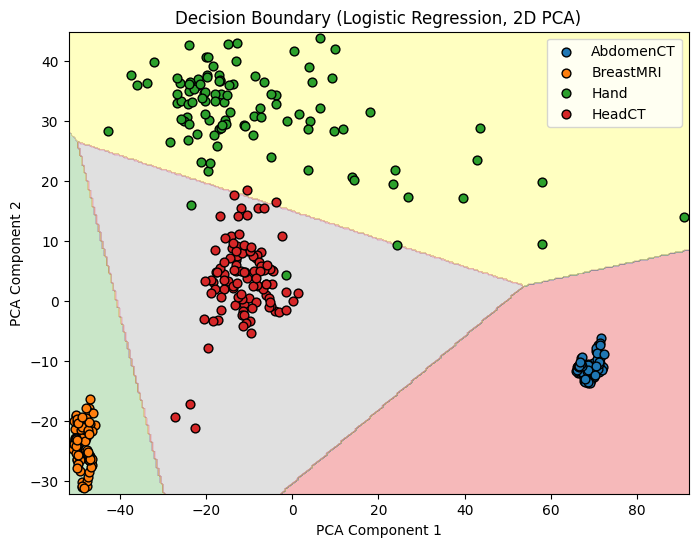

In [79]:
# Plotting decision boundary using the first two PCA components
import numpy as np
import matplotlib.pyplot as plt

# Reduce data to 2D for visualization
X_train_2d = X_train_pca[:, :2]
X_test_2d = X_test_pca[:, :2]

# Retrain classifier on 2D PCA data for visualization
clf_2d = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
clf_2d.fit(X_train_2d, y_train)

# Create a mesh to plot the decision boundary
x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
Z = clf_2d.predict(np.c_[xx.ravel(), yy.ravel()])

# Map class labels to integer indices for contourf
class_labels, Z_int = np.unique(y_train, return_inverse=True)
label_to_int = {label: idx for idx, label in enumerate(class_labels)}
Z_int = np.array([label_to_int[label] for label in Z])
Z_int = Z_int.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z_int, alpha=0.3, cmap=plt.cm.Set1)

# Plot training points
for class_label in np.unique(y_train):
    idx = np.where(y_train == class_label)
    plt.scatter(X_train_2d[idx, 0], X_train_2d[idx, 1], label=class_label, edgecolor='k', s=40)

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary (Logistic Regression, 2D PCA)')
plt.legend()
plt.show()